In [72]:
import pandas as pd
from tqdm import tqdm
from ast import literal_eval
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
def flatten(t):
    return [item for sublist in t for item in sublist]

def custom_eval(x):
    if str(x)=='nan':
        return []
    if str(x)=='[None]':
        return []
    if type(x)==list:
        return x
    else:
        return literal_eval(x)

In [90]:
full_turkey_df = pd.read_csv('ifrc_turkey_2022_10_03.csv')

full_turkey_df = full_turkey_df.drop(
    columns=[
        "id_entry",
        "excerpt",
        "created_by_id",
        "modified_by_id",
        "entry_type",
        "comment",
        "reliability",
        "project_id",
        "modified_at",
        "operational_environment_pillars",
        "sectoral_information_pillars",
        "severity",
        "sectoral_information_verbose_tags",
        "analysis_framework_id",
        "title",
        "sectoral_information_sub_sectors"
    ]
).rename(columns={
    "sectoral_information_sectors": "sectors",
    "operational_environment_sub_pillars": "subpillars_1d",
    "sectoral_information_sub_pillars": "subpillars_2d"
})

for subpillar_col in ['subpillars_2d', 'subpillars_1d']:
    full_turkey_df[subpillar_col] = full_turkey_df[subpillar_col].apply(
        lambda x: list(set(['->'.join(pillar_subpillar_tuple) for pillar_subpillar_tuple in custom_eval(x)]))
    )
    pillar_col = subpillar_col.replace('sub', '')
    full_turkey_df[pillar_col] = full_turkey_df[subpillar_col].apply(
        lambda x: list(set([subpillar.split('->')[0] for subpillar in custom_eval(x)]))
    )

sentiments_df = pd.read_csv("sentiments_turkey_df.csv.gz", compression="gzip")

full_sentiments_df = pd.merge(left=full_turkey_df, right=sentiments_df, on="id")
full_sentiments_df["created_at"] = pd.to_datetime(full_sentiments_df.created_at).apply(lambda x: x.date)


In [96]:
full_sentiments_df.head(2)

,id,created_at,lead_id,specific_needs_groups,location,sectors,subpillars_2d,affected_groups,demographic_groups,response_type,...,pillars_2d,pillars_1d,excerpt,Negative,Neutral,Positive,joy,optimism,anger,sadness
0,574620,2022-05-05,67451,[],[528574],[],[],"['Affected', 'Displaced', 'Refugees (internati...",[],[],...,[],[Displacement],The Afghan diaspora in Turkey live in fear: xe...,0.878788,0.114253,0.006959,0.649305,0.008895,0.047526,0.294274
1,574621,2022-05-05,67451,[],[528574],[],[],"['Affected', 'Migrants']",[],[],...,[],[Displacement],Turkey has been hosting one of the world's lar...,0.698205,0.282388,0.019407,0.418035,0.032364,0.066614,0.482987


In [111]:
from datetime import date, timedelta

today = date.today()

def allsundays(year):
    days_list = []
    d = date(year, 4, 1)                    # January 1st
    d += timedelta(days = 6 - d.weekday())  # First Sunday
    while d < today:
        d += timedelta(days = 14)
        days_list.append(d)
    return days_list[:-1]

days = allsundays(2022)

In [112]:
full_sentiments_df.shape, full_sentiments_df.columns

((31951, 23),
 Index(['id', 'created_at', 'lead_id', 'specific_needs_groups', 'location',
        'sectors', 'subpillars_2d', 'affected_groups', 'demographic_groups',
        'response_type', 'flag_pillars', 'flag_sub_pillars', 'subpillars_1d',
        'pillars_2d', 'pillars_1d', 'excerpt', 'Negative', 'Neutral',
        'Positive', 'joy', 'optimism', 'anger', 'sadness'],
       dtype='object'))

In [113]:
all_tags = flatten(full_sentiments_df.demographic_groups.apply(lambda x: [item.split('->')[0] for item in custom_eval(x)]))
Counter(all_tags).most_common(10)

[('Children (< 18 years)', 2540),
 ('Adult Female (18 to 59 years old)', 322),
 ('Adult (18 to 59 years old)', 198),
 ('Older Persons (60+ years old)', 189),
 ('Youth (12 to 17 years old)', 170),
 ('Adult Male (18 to 59 years old)', 107),
 ('Infants/Toddlers (<5 years old)', 103),
 ('Children (5 to 11 years old)', 84),
 ('Female Older Persons (60+ years old)', 67),
 ('Youth Female (12 to 17 years old)', 42)]

In [125]:
most_relevant_sectors = [
    "Livelihoods",
    "Protection",
    #"Food Security",
    #"Shelter",
    "Education",
    "Health",
    #"WASH",
]
most_relevant_pillars_1d = ["Displacement", "Context"]
most_relevant_pillars_2d = [
    "CAPACITIES & RESPONSE",
    "HUMANITARIAN CONDITIONS",
    "IMPACT",
    "PRIORITIES",
]
most_relevant_affected_groups = [
    "Affected",
    "Displaced",
    "Refugees (temporary protection)",
    "Syrians",
    "Refugees (international protection)",
    "Non Displaced",
    "Host",
]
most_relevant_demographic_groups = ["Children (< 18 years)"]

relevant_sentiment_emotion_cols = [
    "Negative",
    "anger",
    "sadness",
]

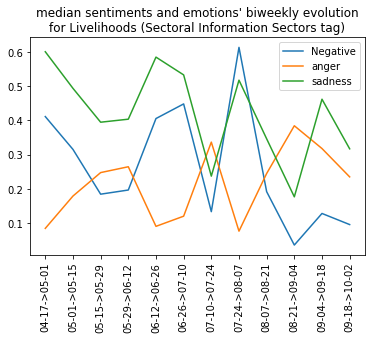

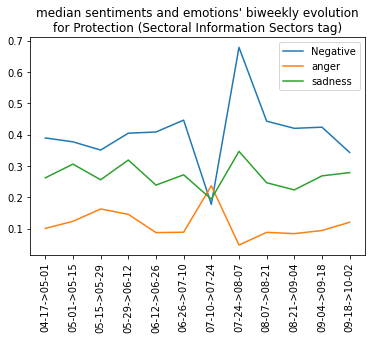

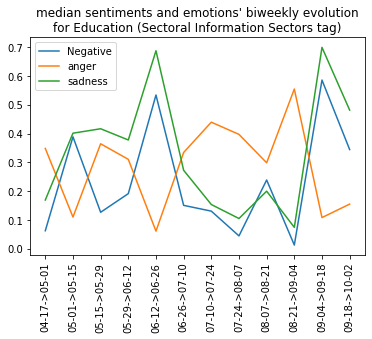

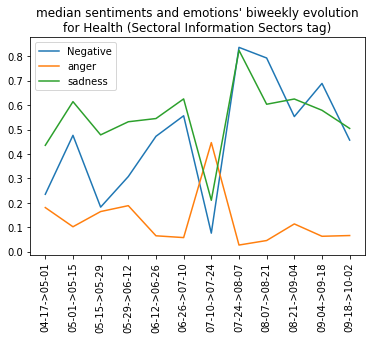

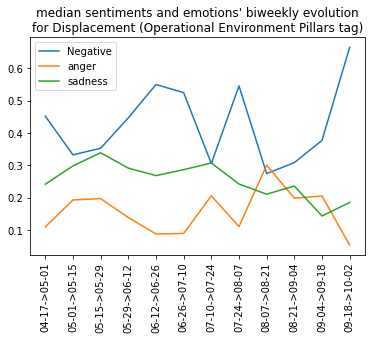

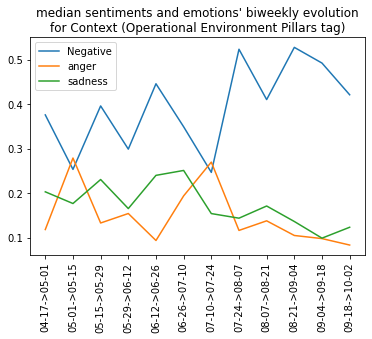

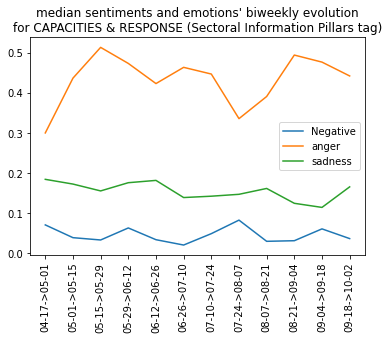

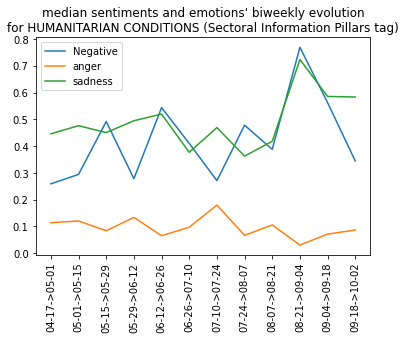

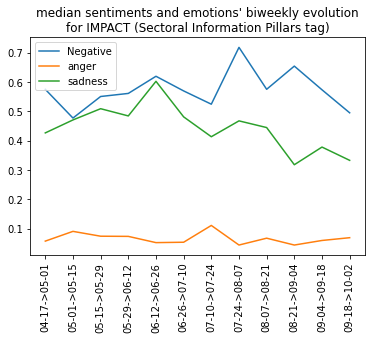

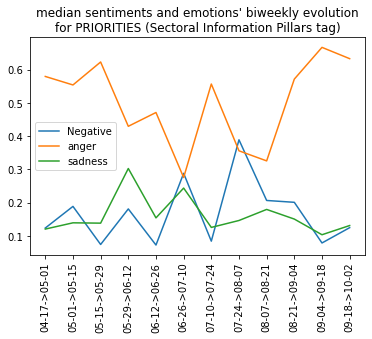

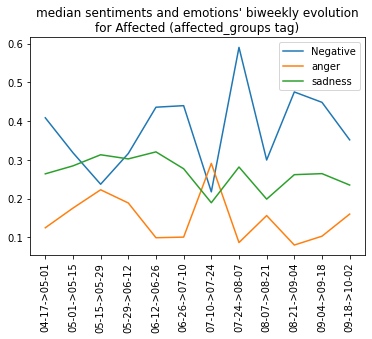

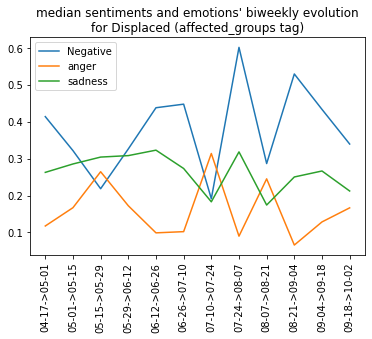

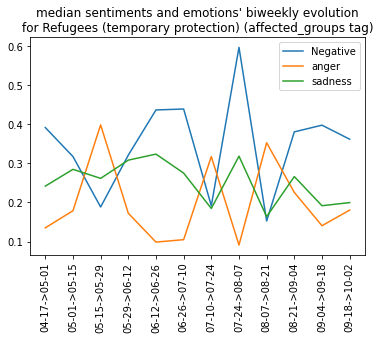

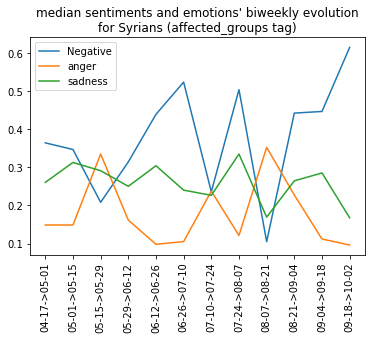

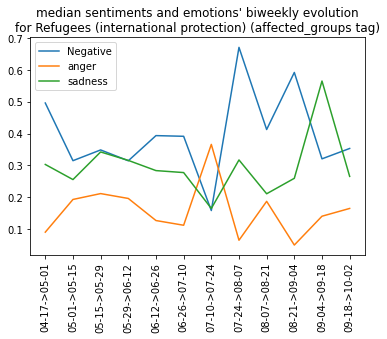

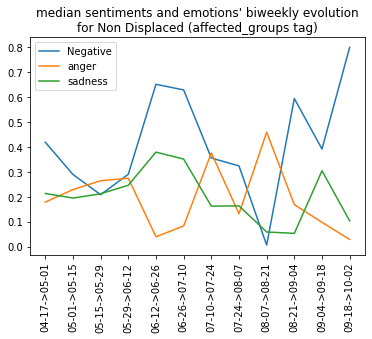

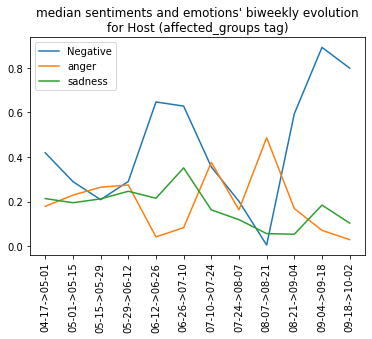

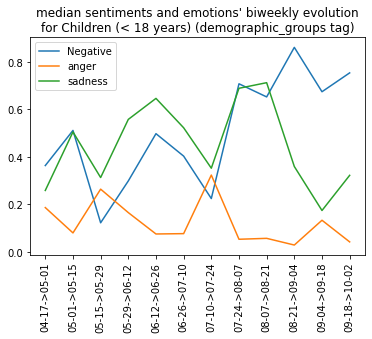

In [126]:
overall_most_relevant_tags = {
    'sectors': most_relevant_sectors,
    'pillars_1d': most_relevant_pillars_1d,
    'pillars_2d': most_relevant_pillars_2d,
    'affected_groups': most_relevant_affected_groups,
    'demographic_groups': most_relevant_demographic_groups    
}

dates = [f'{days[i]}->{days[i+1]}'.replace('2022-', '') for i in range (len(days) - 1)]

for column_name, most_relevant_tags_one_col in overall_most_relevant_tags.items():
    for one_tag in most_relevant_tags_one_col:
        sentiments_results_one_tag = defaultdict()
        plt.figure()
        df_one_tag = full_sentiments_df[full_sentiments_df[column_name].apply(lambda x: one_tag in custom_eval(x))]
        for one_sentiment in relevant_sentiment_emotion_cols:
            sentiments_results_one_tag = []
            for i in range (len(days) - 1):
                start_date = days[i]
                end_date = days[i + 1]
                one_week_one_tag_df = df_one_tag[df_one_tag.created_at.apply(lambda x: x>=start_date and x<end_date)]

                sentiments_results_one_tag.append(one_week_one_tag_df[one_sentiment].median())

            plt.plot(dates, sentiments_results_one_tag, label=f'{one_sentiment}')
            plt.legend()

        if column_name=='pillars_1d': 
            final_col_name = "Operational Environment Pillars"
        elif column_name=='sectors':
            final_col_name = "Sectoral Information Sectors"
        elif column_name=='pillars_2d':
            final_col_name = "Sectoral Information Pillars"
        else:
            final_col_name = column_name

        plt.title(f"median sentiments and emotions' biweekly evolution\nfor {one_tag} ({final_col_name} tag)")
        plt.xticks(rotation=90)
        plt.show()                